# GEOG5405M Urban Data Science Project (38539)

# Optimal Location Framework for Electric Vehicle Charging Stations
# ——A case study of Seattle, Washington

# Project Outline

1. Introduction  

2. Data Collection  
 2.1 EVCS data  
 2.2 Point of Interets data  

3. Data Wrangling  
 3.1 EVCS data  
 3.2 Point of Interets data  
 3.3 Census data  
 3.4 Traffic flow data  

4. Exploratory Data Analysis   
 4.1 Descriptive Statistical Analysis  
 4.2 Spatial Autocorrelation Analysis  

5. Maximal Coverage Location Problem    
 5.1 Integration of demand point data    
 5.2 Potential facility sites   
 5.3 Number of facilities constructed and radius of service      
 5.4 Analysis of existing charging pile coverage  
 5.5 Optimization Result     
    
6. Conclusion   

   References  

       

<br> <br> 

# 1.Introduction

The development of charging infrastructure has been slowed by the "chicken or egg" dilemma, whereby consumers are reluctant to buy pure electric vehicles unless they are ready to connect to charging infrastructure, and the industry is reluctant to invest heavily in pure electric vehicle technology and infrastructure without enough consumers (Struben, J. and Sterman, J.D., 2008)  
 However, installing a public charging station can be costly, and home charging posts have subsequently been strongly encouraged to be installed. Although one of the advantages of home charging is the lower cost of residential electricity compared to the cost of a public charging station and the cost of gas, not every home has a parking space for charging, and home chargers are only for the whole family and do not take into account the rest of the community, especially taxi drivers and long-distance car drivers who suffer from "mileage anxiety". This does not take into account the rest of society, especially cab drivers and coach drivers who suffer from 'mileage anxiety'. Range Anxiety (RA) is the fear of completely draining a BEV battery during a trip. Unlike conventional fuel vehicles, most non-fast charging modes make charging time significantly longer than refueling. If EV charging posts can be conveniently located in areas with dense transportation routes or close to residential areas, owners can easily and smoothly find the charging posts, helping to alleviate their mileage anxiety. Therefore, how to install charging piles in places with high accessibility and coverage is a siting issue worth exploring.  
 As a result of transportation inequities caused by high transit costs, Seattle proposed policies (Seattle Department of Transportation, 2023) that would allow electric vehicle (EV) charging stations to be installed on the curb at locations where public right-of-way is sufficient to meet the requirements of the pilot program. The plan aims to serve high-mileage carpool drivers while meeting the charging needs of more potential electric vehicle drivers (such as those without home charging piles), pursue fairness and justice in charging, and reduce losses caused by electric vehicle owners due to electric vehicle charging . Charging stations are expensive. As of summer 2022, City Lights Seattle has received nearly 2,000 requests from community members for proposals for siting roadside charging stations.  

This project aims to use the location model of the maximum coverage problem to set the bus station as a potential facility for electric vehicle charging and construct a demand model consisting of the centroid of the census, the centroid of the annual average working day traffic flow, and poi. 

# 2.Data Collection

The data for this study, comprising Seattle EVCS data, neighborhood boundaries, traffic flow data, census boundaries, and POIs, is described in five sections, and the source websites are as follows:    
    1.EVCS data: https://chargehub.com/en/Charging-Stations-Map.html  
    2.POIs:  https://overpass-turbo.eu/  
    3.Bus stops data: https://mygeodata.cloud/result  
    4.Neighborhood boundaries: https://data.seattle.gov/dataset/Neighborhood-Map-Atlas-Neighborhoods/h6sh-ea6k  
    5.Census boundaries: https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2020-census-tracts-seattle/explore  
    6.Traffic flow data: https://data.seattle.gov/dataset/2017-Traffic-Flow-Counts/svf4-9bss  
Among them, EVCS data need to be crawled, POI data need to call overpy to get data from OSM server, and all other data can be downloaded directly from the webpage.  
   

## 2.1 Seattle EVCS data

In [1]:
import random
import re
import requests
from lxml import etree
import openpyxl
from bs4 import BeautifulSoup
import time
# Defining proxy settings
proxies = {
   "http": "http://127.0.0.1:7890",
   "https": "http://127.0.0.1:7890",
}

#Defining request header parameters
headers = {
    'authority': 'apiv2.chargehub.com',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'accept-language': 'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
    'cache-control': 'no-cache',
    'origin': 'https://chargehub.com',
    'pragma': 'no-cache',
    'referer': 'https://chargehub.com/',
    'sec-ch-ua': '"Not/A)Brand";v="99", "Microsoft Edge";v="115", "Chromium";v="115"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36 Edg/115.0.1901.188',
    'x-auth': 'null',
}
# Defining request parameters
params = (
    ('latmin', '47.4957'),
    ('latmax', '47.7341'),
    ('lonmin', '-122.4359'),
    ('lonmax', '-122.2362'),
    ('limit', '2000'),
    ('key', 'olitest'),
    ('remove_networks', ''),
    ('remove_levels', ''),
    ('remove_connectors', ''),
    ('remove_other', ''),
    ('above_power', '0'),
    ('show_pending', '1'),
)
# Create a new Excel workbook and get the active worksheet
wb=openpyxl.Workbook()
ws=wb.active

# add column names in the first row of the worksheet
ws.append(['id','lat','long','address','postcode','total port','detail','area'])

# Send a GET request to the specified URL to get the charging station location data on the map
response = requests.get('https://apiv2.chargehub.com/api/locationsmap', headers=headers, params=params)

# Parsing the returned JSON data
json_data=response.json()
print(len(json_data))

#Iterate over the returned charging station data
for index,i in enumerate(json_data):
    print(index)
    LocID=i['LocID']
    params2 = (
        ('station_id', LocID),
        ('language', 'en'),
    )
    #Try to send a GET request to get the details of the charging station
    try:
        response = requests.get('https://apiv2.chargehub.com/api/stations/details', headers=headers, params=params2)
    except:
        response = requests.get('https://apiv2.chargehub.com/api/stations/details', headers=headers, params=params2)

    #Parsing the returned JSON data to get charging station details    
    json_data2=response.json()['station']
    Lat=json_data2['Lat']
    Long=json_data2['Long']
    Address=json_data2['Address']
    print(Address)
    TotalPorts=json_data2['TotalPorts']
    #Type and number of extraction plugs
    Level_lst=[]
    for l in json_data2['PlugsArray']:
        Level_lst.append(l['Level'])

    Name_lst=[]
    for l in json_data2['PlugsArray']:
        Name_lst.append(l['Name'])
    Count_lst=[]
    for l in json_data2['PlugsArray']:
        Count_lst.append(l['Count'])
    #Extracting zip codes and area names from addresses
    postcode=Address.split(',')[-1]
    area=Address.split(',')[-3]
    time.sleep(1)
    #Create a list where each element is a dictionary containing the level, name and number of plugs
    lst=[]
    for Level,Name,Count in zip(Level_lst,Name_lst,Count_lst):
        d={'level':Level,'name':Name,'count':Count}
        lst.append(d)
    print(lst)
    #Add the extracted information to a new row in the Excel worksheet and save
    ws.append([LocID,Lat,Long,Address,postcode,TotalPorts,str(lst),area])
    wb.save('evcs.xlsx')


D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


257
0
516 Harrison Street, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 6}]
1
214 Columbia Street, Seattle, WA, 98104
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
2
1000 4th Avenue, Seattle, WA, 98104
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 3}]
3
6330 35th Avenue Southwest, Seattle, WA, 98126
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
4
9456 16th Avenue Southwest, Seattle, WA, 98106
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
5
8500 15th Avenue NW, Ste A, Seattle, WA, 98117
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
6
101 Elliott Avenue West, Seattle, WA, 98121
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
7
1600 East Madison Street, Seattle, WA, 98122
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
8
999 Third Avenue, Level A, Seattle, WA, 98104
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
9
200 West Mercer Street, Seattle, WA, 98119
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
1

810 Dexter Ave., North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
76
300 8th Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
77
100 Stewart Street, Seattle, WA, 98101
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}, {'level': 2, 'name': 'Tesla', 'count': 1}]
78
550 Terry Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
79
535 Terry Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
80
500 Boren Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
81
345 Boren Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
82
207 Boren Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 7}]
83
2021 7th Avenue, Seattle, WA, 98121
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 26}]
84
2121 7th Avenue, Seattle, WA, 98121
[{'level': 2, 'name': 'EV Plug (J

[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 6}]
152
4412 Rainier Avenue South, Seattle, WA, 98118
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
153
818 Stewart Street, Seattle, WA, 98101
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 5}, {'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
154
Sportsfield Drive Northeast, Seattle, WA, 98115
[{'level': 3, 'name': 'CCS & CHAdeMO', 'count': 2}]
155
1325 6th Avenue, Seattle, WA, 98101
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}, {'level': 2, 'name': 'Tesla', 'count': 3}]
156
1406 Harvard Avenue, Seattle, WA, 98122
[{'level': 3, 'name': 'CCS & CHAdeMO', 'count': 1}]
157
2125 1st Avenue, Seattle, WA, 98121
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
158
6000 16th Avenue Southwest, Seattle, WA, 98106
[{'level': 3, 'name': 'CCS & CHAdeMO', 'count': 1}]
159
1416 Northwest Ballard Way, Seattle, WA, 98107
[{'level': 3, 'name': 'Tesla Supercharger', 'count': 8}]
160
1220 Howell Street, Seattle, WA, 98101
[{'leve

[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 5}]
226
700 Roy Street, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 8}, {'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
227
1st Avenue South & South Stacy Street, Seattle, WA, 98134
[{'level': 3, 'name': 'CCS & CHAdeMO', 'count': 4}]
228
1007 First Avenue, Seattle, WA, 98104
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
229
1800 9th Avenue, Seattle, WA, 98101
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
230
3401 South Norfolk Street, Seattle, WA, 98118
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]
231
700 5th Avenue, Seattle, WA, 98104
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
232
1009 Olive Way, Seattle, WA, 98101
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 8}]
233
2915 Fuhrman Avenue East, Seattle, WA, 98102
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]
234
140 4th Avenue North, Seattle, WA, 98109
[{'level': 2, 'name': 'EV Plug (J1772)', 'count': 8}]
235


## 2. POI Data

Points of interest include residential areas, commercial area, schools and hospitals

In [2]:
import overpy
import geopandas as gpd
from shapely.geometry import Point

def get_pois(poi_type):
    api = overpy.Overpass()
    
    # Check the POI type to determine the key used in the query
    if poi_type in ['residential', 'commercial']:
        key = "landuse"
    elif poi_type in ['hospital', 'school']:
        key = "amenity"
    else:
        print("Invalid POI type")
        return None
    
    # build query
    query = f"""
    [out:json];
    area[name="Seattle"][admin_level=8][boundary=administrative]->.searchArea;
    (
      node["{key}"="{poi_type}"](area.searchArea);
      way["{key}"="{poi_type}"](area.searchArea);
      relation["{key}"="{poi_type}"](area.searchArea);
    );
    out center;
    """
    
    # perform query
    result = api.query(query)

    # convert to Geopandas GeoDataFrame
    data = {
        "osmid": [node.id for node in result.nodes] + [way.id for way in result.ways],
        "geometry": [Point((node.lon, node.lat)) for node in result.nodes] + 
                   [Point((way.center_lon, way.center_lat)) for way in result.ways],
    }
    gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
    gdf['type'] = poi_type
    
    return gdf

# Using functions to get different types of POI data
residential_gdf = get_pois("residential")
commercial_gdf = get_pois("commercial")
hospital_gdf = get_pois("hospital")
school_gdf = get_pois("school")

# print the head of each gdf
print(residential_gdf.head())
print(commercial_gdf.head())
print(hospital_gdf.head())
print(school_gdf.head())


C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2844\4228921199.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth

        osmid                     geometry         type
0  2351724014  POINT (-122.33459 47.59930)  residential
1  2375303494  POINT (-122.31563 47.60643)  residential
2  2400859049  POINT (-122.35893 47.62692)  residential
3  3006168299  POINT (-122.34550 47.61438)  residential
4  3006173098  POINT (-122.31989 47.59954)  residential
      osmid                     geometry        type
0  30004460  POINT (-122.29659 47.71743)  commercial
1  37547843  POINT (-122.34082 47.70052)  commercial
2  38931549  POINT (-122.34395 47.69110)  commercial
3  38931562  POINT (-122.34396 47.69201)  commercial
4  38931572  POINT (-122.34397 47.69296)  commercial
        osmid                     geometry      type
0   356551783  POINT (-122.36622 47.53444)  hospital
1  9525009816  POINT (-122.32421 47.60917)  hospital
2    38522975  POINT (-122.33712 47.71413)  hospital
3    53615315  POINT (-122.30826 47.56301)  hospital
4   169511257  POINT (-122.32383 47.60431)  hospital
       osmid                

# 3.Data Import and wrangling

## 3.1 Data import

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [4]:
# Read EVCS data
df = pd.read_excel('evcs.xlsx', engine='openpyxl')
# Read Neighborhood Data
gdf = gpd.read_file("data/Neighborhood_Map_Atlas_Neighborhoods/Neighborhood_Map_Atlas_Neighborhoods.shp")
gdf = gdf.to_crs(epsg=4326)
# Read bus stops data
bus_stops = gpd.read_file("data/bus stops/bus_stop_point.shp")
# Read traffic flow data
traffic_gdf = gpd.read_file("data/2017_Traffic_Flow_Counts.geojson")
# Read Census Tract data
census_gdf = gpd.read_file('data/2020_Census_Tracts_-_Seattle/tract20_king_county.shp')

# 3.2 EVCS data

In [5]:
from shapely.geometry import Point
# Creating Geometric Columns
df['geometry'] = df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
# Convert the DataFrame to a GeoDataFrame and set the reference coordinate system (WGS 84 coordinate system is used here)
evcs_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
evcs_gdf

id        lat        long  \
0     19235  47.622085 -122.347124   
1     20020  47.604201 -122.333251   
2     21010  47.606684 -122.332664   
3     35773  47.545464 -122.376410   
4     35774  47.517917 -122.354531   
..      ...        ...         ...   
252  134864  47.546955 -122.328873   
253  135148  47.621539 -122.360298   
254  135151  47.614840 -122.324167   
255  135169  47.616097 -122.352719   
256  136381  47.629300 -122.339449   

                                            address  postcode  total port  \
0           516 Harrison Street, Seattle, WA, 98109     98109           6   
1           214 Columbia Street, Seattle, WA, 98104     98104           2   
2               1000 4th Avenue, Seattle, WA, 98104     98104           3   
3    6330 35th Avenue Southwest, Seattle, WA, 98126     98126           1   
4    9456 16th Avenue Southwest, Seattle, WA, 98106     98106           1   
..                                              ...       ...         ...   
252       6100 4th Avenue South, Seattle, WA, 98108     98108           4   
253         330 3rd Avenue West, Seattle, WA, 98119     98119           4   
254         1530 Belmont Avenue, Seattle, WA, 98122     98122           8   
255         2800 Western Avenue, Seattle, WA, 98121     98121           4   
256  1200 Westlake Avenue North, Seattle, WA, 98109     98109           6   

                                                detail      area  \
0    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
1    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
2    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
3    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
4    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
..                                                 ...       ...   
252  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
253  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
254  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
255  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
256  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   

                        geometry  
0    POINT (-122.34712 47.62208)  
1    POINT (-122.33325 47.60420)  
2    POINT (-122.33266 47.60668)  
3    POINT (-122.37641 47.54546)  
4    POINT (-122.35453 47.51792)  
..                           ...  
252  POINT (-122.32887 47.54696)  
253  POINT (-122.36030 47.62154)  
254  POINT (-122.32417 47.61484)  
255  POINT (-122.35272 47.61610)  
256  POINT (-122.33945 47.62930)  

[257 rows x 9 columns]

In [6]:
# Retention of evcs within neighborhoods
df2 = gpd.sjoin(evcs_gdf, gdf, how="inner", op="within")
df2

D:\anaconda\anacon\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


id        lat        long  \
0     19235  47.622085 -122.347124   
9     36018  47.624604 -122.359318   
94    61182  47.625675 -122.346886   
96    61188  47.625378 -122.344596   
123   70247  47.623397 -122.345681   
..      ...        ...         ...   
230  123908  47.512000 -122.288090   
233  128366  47.648127 -122.317529   
242  133700  47.600250 -122.297220   
247  134190  47.689356 -122.376590   
250  134718  47.726584 -122.347325   

                                               address  postcode  total port  \
0              516 Harrison Street, Seattle, WA, 98109     98109           6   
9           200 West Mercer Street, Seattle, WA, 98119     98119           2   
94            500 5th Avenue North, Seattle, WA, 98109     98109           2   
96                  601 Roy Street, Seattle, WA, 98109     98109           2   
123           500 5th Avenue North, Seattle, WA, 98109     98109           8   
..                                                 ...       ...         ...   
230      3401 South Norfolk Street, Seattle, WA, 98118     98118           4   
233       2915 Fuhrman Avenue East, Seattle, WA, 98102     98102           2   
242  241 Martin Luther King Junior Way South, Seatt...     98144           1   
247     8340 15th Avenue Northwest, Seattle, WA, 98117     98117           4   
250      13280 Linden Avenue North, Seattle, WA, 98133     98133           2   

                                                detail      area  \
0    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
9    [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
94         [{'level': 2, 'name': 'Tesla', 'count': 2}]   Seattle   
96         [{'level': 2, 'name': 'Tesla', 'count': 2}]   Seattle   
123  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
..                                                 ...       ...   
230  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
233  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
242  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   
247  [{'level': 3, 'name': 'CCS & CHAdeMO', 'count'...   Seattle   
250  [{'level': 2, 'name': 'EV Plug (J1772)', 'coun...   Seattle   

                        geometry  index_right  OBJECTID        L_HOOD  \
0    POINT (-122.34712 47.62208)           18        45    Queen Anne   
9    POINT (-122.35932 47.62460)           18        45    Queen Anne   
94   POINT (-122.34689 47.62568)           18        45    Queen Anne   
96   POINT (-122.34460 47.62538)           18        45    Queen Anne   
123  POINT (-122.34568 47.62340)           18        45    Queen Anne   
..                           ...          ...       ...           ...   
230  POINT (-122.28809 47.51200)           54        81   Beacon Hill   
233  POINT (-122.31753 47.64813)           70        97  Capitol Hill   
242  POINT (-122.29722 47.60025)           31        58  Central Area   
247  POINT (-122.37659 47.68936)            2        29       Ballard   
250  POINT (-122.34732 47.72658)           81       111     Northwest   

                S_HOOD                            S_HOOD_ALT    Shape__Are  \
0     Lower Queen Anne                Uptown, Seattle Center  1.751562e+07   
9     Lower Queen Anne                Uptown, Seattle Center  1.751562e+07   
94    Lower Queen Anne                Uptown, Seattle Center  1.751562e+07   
96    Lower Queen Anne                Uptown, Seattle Center  1.751562e+07   
123   Lower Queen Anne                Uptown, Seattle Center  1.751562e+07   
..                 ...                                   ...           ...   
230  South Beacon Hill                                   NaN  3.844883e+07   
233        Portage Bay                          Roanoke Park  4.421635e+06   
242           Atlantic  Judkins Park, Jackson Place, Coleman  2.066499e+07   
247   Whittier Heights                                   NaN  1.419569e+07   
250        Bitter Lake                 

In [7]:
# Set up to display full column contents
pd.set_option('display.max_colwidth', -1)  
print(df2['detail'])

0      [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 6}]                                                     
9      [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                     
94     [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                               
96     [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                               
123    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 7}, {'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]
                                                          ...                                                    
230    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]                                                     
233    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                     
242    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]                            

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2844\2872566144.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [8]:
# Extract the information from the detail
import ast

# Define the extraction function
def extract_level_and_name(cell):
    extracts = []

    # If it's a string, try converting it to a list
    if isinstance(cell, str):
        try:
            cell = ast.literal_eval(cell)
        except:
            return None  # Returns None if the conversion fails

    for item in cell:
        level = item.get('level', None)
        name = item.get('name', None)
        if level and name:
            extracts.append(f"{level}, {name}")
            
    return '; '.join(extracts)

# Applying Extract Functions to New Columns
df2['extracted'] = df2['detail'].apply(extract_level_and_name)
# For the semicolon substitute
df2['extracted'] = df2['extracted'].str.replace(';', ',')

print(df2[['detail', 'extracted']])


                                                                                                         detail  \
0    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 6}]                                                        
9    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                        
94   [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                                  
96   [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                                  
123  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 7}, {'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]   
..                                                                                                          ...   
230  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]                                                        
233  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                      

In [9]:
import re

def extract_info(cell):
    # Extract all separate numbers before a comma from a string using a regular expression
    numbers = re.findall(r"\b\d+\b(?=,)", cell)
    levels = ', '.join(numbers)
    
    # Remove already extracted numbers
    for num in numbers:
        cell = cell.replace(num + ',', '').strip()
    
    return levels, cell

# Apply the function and create a new column
df2['level'], df2['type'] = zip(*df2['extracted'].apply(extract_info))

# print(df2[['extracted', 'level', 'type']])

# Remove spaces
df2['type'] = df2['type'].str.replace(' ', '')
df2


id        lat        long  \
0    19235   47.622085 -122.347124   
9    36018   47.624604 -122.359318   
94   61182   47.625675 -122.346886   
96   61188   47.625378 -122.344596   
123  70247   47.623397 -122.345681   
..     ...         ...         ...   
230  123908  47.512000 -122.288090   
233  128366  47.648127 -122.317529   
242  133700  47.600250 -122.297220   
247  134190  47.689356 -122.376590   
250  134718  47.726584 -122.347325   

                                                         address  postcode  \
0    516 Harrison Street, Seattle, WA, 98109                      98109      
9    200 West Mercer Street, Seattle, WA, 98119                   98119      
94   500 5th Avenue North, Seattle, WA, 98109                     98109      
96   601 Roy Street, Seattle, WA, 98109                           98109      
123  500 5th Avenue North, Seattle, WA, 98109                     98109      
..                                        ...                       ...      
230  3401 South Norfolk Street, Seattle, WA, 98118                98118      
233  2915 Fuhrman Avenue East, Seattle, WA, 98102                 98102      
242  241 Martin Luther King Junior Way South, Seattle, WA, 98144  98144      
247  8340 15th Avenue Northwest, Seattle, WA, 98117               98117      
250  13280 Linden Avenue North, Seattle, WA, 98133                98133      

     total port  \
0    6            
9    2            
94   2            
96   2            
123  8            
..  ..            
230  4            
233  2            
242  1            
247  4            
250  2            

                                                                                                         detail  \
0    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 6}]                                                        
9    [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                        
94   [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                                  
96   [{'level': 2, 'name': 'Tesla', 'count': 2}]                                                                  
123  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 7}, {'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]   
..                                                                                                          ...   
230  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 4}]                                                        
233  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                        
242  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 1}]                                                        
247  [{'level': 3, 'name': 'CCS & CHAdeMO', 'count': 4}]                                                          
250  [{'level': 2, 'name': 'EV Plug (J1772)', 'count': 2}]                                                        

         area                     geometry  index_right  OBJECTID  \
0     Seattle  POINT (-122.34712 47.62208)  18           45         
9     Seattle  POINT (-122.35932 47.62460)  18           45         
94    Seattle  POINT (-122.34689 47.62568)  18           45         
96    Seattle  POINT (-122.34460 47.62538)  18           45         
123   Seattle  POINT (-122.34568 47.62340)  18           45         
..        ...                          ...  ..           ..         
230   Seattle  POINT (-122.28809 47.51200)  54           81         
233   Seattle  POINT (-122.31753 47.64813)  70           97         
242   Seattle  POINT (-122.29722 47.60025)  31           58         
247   Seattle  POINT (-122.37659 47.68936)  2            29         
250   Seattle  POINT (-122.34732 47.72658)  81           111        

           L_HOOD             S_HOOD                            S_HOOD_ALT  \
0    Queen Anne    Lower Queen Anne   Uptown, Seattle Center                 
9    Queen Anne    L

## 3.2 POI Data

In [10]:
# Combining all geodataframes
poi_gdfs = [residential_gdf, commercial_gdf, hospital_gdf, school_gdf]

# Use the pandas.concat method to combine them together
poi_gdf = pd.concat(poi_gdfs, ignore_index=True)

print(poi_gdf.head())


        osmid                     geometry         type
0  2351724014  POINT (-122.33459 47.59930)  residential
1  2375303494  POINT (-122.31563 47.60643)  residential
2  2400859049  POINT (-122.35893 47.62692)  residential
3  3006168299  POINT (-122.34550 47.61438)  residential
4  3006173098  POINT (-122.31989 47.59954)  residential


In [11]:
# Ensure that both GeoDataFrames have the same CRS
if poi_gdf.crs != gdf.crs:
    poi_gdf = poi_gdf.to_crs(gdf.crs)

# Use sjoin to determine which POIs are within each neighborhood
joined = gpd.sjoin(poi_gdf, gdf, how="inner", op="within")

# Create a new GeoDataFrame with only those POIs that are in the neighborhood_gdf
pois_within_neighborhood = poi_gdf[poi_gdf.index.isin(joined.index)]

# Display the filtered POIs
print(pois_within_neighborhood.head())


        osmid                     geometry         type
0  2351724014  POINT (-122.33459 47.59930)  residential
1  2375303494  POINT (-122.31563 47.60643)  residential
2  2400859049  POINT (-122.35893 47.62692)  residential
3  3006168299  POINT (-122.34550 47.61438)  residential
4  3006173098  POINT (-122.31989 47.59954)  residential


D:\anaconda\anacon\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
#Keep only geometry and type
pois_within_neighborhood = pois_within_neighborhood[['geometry','type']]
pois_within_neighborhood

geometry         type
0     POINT (-122.33459 47.59930)  residential
1     POINT (-122.31563 47.60643)  residential
2     POINT (-122.35893 47.62692)  residential
3     POINT (-122.34550 47.61438)  residential
4     POINT (-122.31989 47.59954)  residential
...                           ...          ...
1393  POINT (-122.32495 47.68002)  school     
1394  POINT (-122.30492 47.58399)  school     
1395  POINT (-122.30596 47.60332)  school     
1396  POINT (-122.29018 47.72132)  school     
1397  POINT (-122.35888 47.64643)  school     

[1390 rows x 2 columns]

## 3.3 Census data

In [13]:
import pulp
# Calculate the census tract of gravity
centroids_gdf = census_gdf.copy()
centroids_gdf['geometry'] = centroids_gdf.geometry.centroid
centroids_gdf['type'] = 'census'
centroids_gdf = centroids_gdf[['geometry', 'type']]
centroids_gdf

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2844\223275027.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_gdf['geometry'] = centroids_gdf.geometry.centroid


geometry    type
0    POINT (-122.35237 47.71686)  census
1    POINT (-122.35542 47.72791)  census
2    POINT (-122.30186 47.71569)  census
3    POINT (-122.37126 47.67601)  census
4    POINT (-122.32604 47.67491)  census
..                           ...     ...
172  POINT (-122.34085 47.60783)  census
173  POINT (-122.29559 47.55321)  census
174  POINT (-122.36203 47.52971)  census
175  POINT (-122.28286 47.52017)  census
176  POINT (-122.26501 47.50500)  census

[177 rows x 2 columns]

## 3.4 Traffic Flow Data

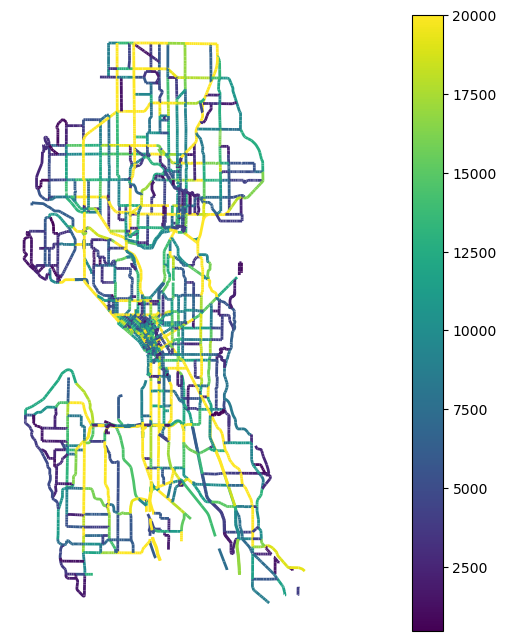

In [14]:
# Calculate the center of mass of the traffic flow
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

min_value = traffic_gdf["AWDT"].min()
max_value = 20000

traffic_gdf.plot(column="AWDT", ax=ax, legend=True, linewidth=2, vmin=min_value, vmax=max_value) 

ax.set_axis_off()
colorbar = ax.get_figure().get_axes()[1] #Get color bar
colorbar.set_anchor((1, 0.5))

plt.show()

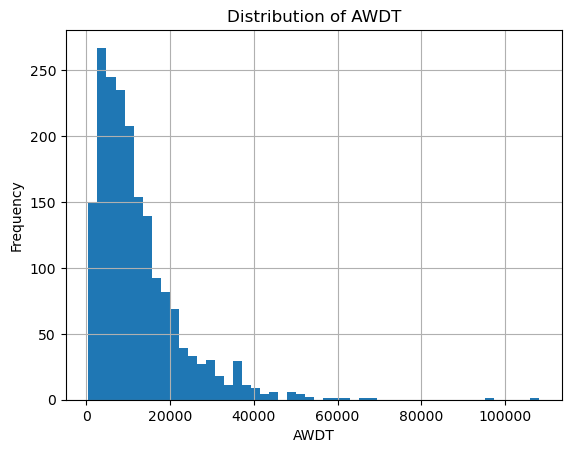

In [15]:
#Plot a histogram and observe the distribution of traffic flow over the threshold
traffic_gdf["AWDT"].hist(bins=50)
plt.xlabel('AWDT')
plt.ylabel('Frequency')
plt.title('Distribution of AWDT')
plt.show()

The distribution is concentrated within the 0-20,000 value, and the distribution is found to be more concentrated before 20,000 and sparser after 20,000, suggesting that any traffic volume above 20,000 is considered to be an exceptionally high roadway. However, our goal was maximum coverage, so we shopped for the option of capturing roadways with moderate traffic.

In [16]:
traffic_gdf["AWDT"].describe()

count    1876.000000  
mean     12138.163113 
std      9977.105367  
min      468.000000   
25%      5265.000000  
50%      9500.000000  
75%      16000.000000 
max      108179.000000
Name: AWDT, dtype: float64

The 25% quartile represents the midpoint between the minimum and median of the traffic flow, and if the 50% quartile is taken to represent all values above the median of the traffic flow, and if it is 75%, then the zombie maximum and all values after the midpoint of the median will represent the 25% of the roadway with the highest flow. And the aim of our study is to maximize the coverage of the demand points, considering the cost and effectiveness, so all values above the median are chosen.

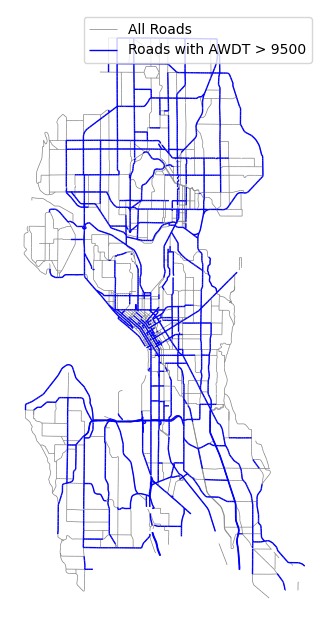

In [18]:
selected_roads = traffic_gdf[traffic_gdf["AWDT"] > 9500]
import matplotlib.pyplot as plt

# Creating a new canvas and axes 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# draw the overall road network as a background, with the color set to gray 
traffic_gdf.plot(ax=ax, color='grey', linewidth=0.5, label='All Roads')

# plot those sections where the AWDT exceeds 9500, with the color set to blue
selected_roads = traffic_gdf[traffic_gdf["AWDT"] > 9500]
selected_roads.plot(ax=ax, color='blue', linewidth=1, label='Roads with AWDT > 9500')

# Add legend
ax.legend()

# Remove Axis
ax.set_axis_off()

# plot
plt.show()


In [19]:
selected_roads_gdf = traffic_gdf[traffic_gdf["AWDT"] > 9500]
traffic_centroids = selected_roads_gdf.geometry.centroid
selected_roads_gdf['centroid'] = traffic_centroids 
selected_roads_gdf['type'] = 'traffic'
selected_roads_gdf = selected_roads_gdf[['centroid', 'type']]
selected_roads_gdf = selected_roads_gdf.rename(columns={'centroid': 'geometry'})
selected_roads_gdf

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2844\4196253827.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  traffic_centroids = selected_roads_gdf.geometry.centroid
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

geometry     type
0     POINT (-122.31342 47.57040)  traffic
2     POINT (-122.33944 47.71231)  traffic
3     POINT (-122.39612 47.63337)  traffic
5     POINT (-122.29623 47.61047)  traffic
7     POINT (-122.31369 47.58684)  traffic
...                           ...      ...
1871  POINT (-122.37622 47.66366)  traffic
1872  POINT (-122.37630 47.66300)  traffic
1873  POINT (-122.37643 47.64847)  traffic
1874  POINT (-122.37636 47.64845)  traffic
1875  POINT (-122.32891 47.57085)  traffic

[932 rows x 2 columns]

# 4.Exploratory Analysis

## 4.1 Descriptive statistical analysis

In [20]:
#plug level analysis

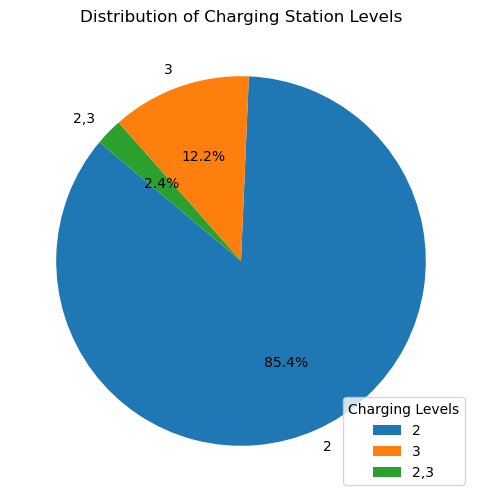

In [21]:
# Define the classification function
def classify_level(level_str):
    if '2' in level_str and '3' in level_str:
        return '2,3'
    elif '2' in level_str:
        return '2'
    else:
        return '3'

# Apply the classification function to the 'level' column
df2['level_group'] = df2['level'].apply(classify_level)

# Counts the values in the 'level_group' column
level_count = df2['level_group'].value_counts()

# Creating Pie Charts
plt.figure(figsize=(10, 6))
plt.pie(level_count, labels=level_count.index, autopct='%1.1f%%', startangle=140)

# Setting the title
plt.title('Distribution of Charging Station Levels')

# Add Legend
plt.legend(level_count.index, title="Charging Levels", loc="best")

# plot
plt.show()

In [22]:
#Plug type analysis
evcs_type = df2.copy()
type_counts = evcs_type['type'].value_counts()
type_counts

EVPlug(J1772)                                182
CCS&CHAdeMO                                  19 
EVPlug(J1772),EVPlug(J1772)                  17 
Tesla                                        8  
EVPlug(J1772),Tesla                          8  
CCS&CHAdeMO,CCS&CCS                          5  
TeslaSupercharger                            4  
EVPlug(J1772),CCS&CHAdeMO                    4  
CCS&CHAdeMO,CCS&CHAdeMO                      2  
EVPlug(J1772),EVPlug(J1772),EVPlug(J1772)    2  
CCS&CHAdeMO,CCS&CHAdeMO,EVPlug(J1772)        1  
EVPlug(J1772),CCS&CHAdeMO,CCS&CCS            1  
TeslaSupercharger,CCS&CHAdeMO,CCS&CCS        1  
Name: type, dtype: int64

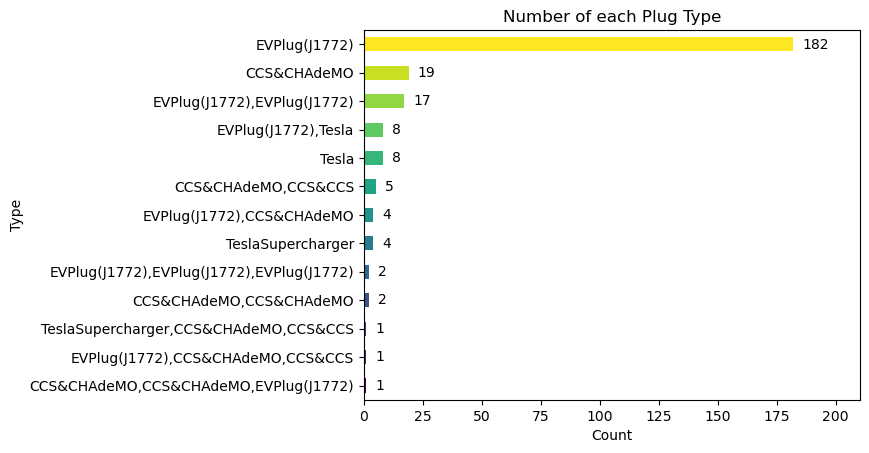

In [23]:
import numpy as np
import matplotlib.pyplot as plt

type_counts = evcs_type['type'].value_counts().sort_values(ascending=True)

# Use matplotlib's default color loop to provide a color for each column
colors = plt.cm.viridis(np.linspace(0, 1, len(type_counts)))

# Plotting a horizontal bar chart and getting the current axis
ax = type_counts.plot(kind='barh', color=colors)
plt.title('Number of each Plug Type')
plt.ylabel('Type')
plt.xlabel('Count')

# Get the upper limit of the x-axis
xlim = ax.get_xlim()

# Add value labels to the right side of each column
for index, value in enumerate(type_counts):
    # Use a small portion of the upper limit of the x-axis to determine the position of the text
    ax.text(value + xlim[1]*0.02, index, str(value), va='center', color='black')

# Adjust the upper limit of the x-axis to fit text labels
ax.set_xlim(0, xlim[1] + xlim[1]*0.1)

plt.show()

## 4.2 Spatial Analysis

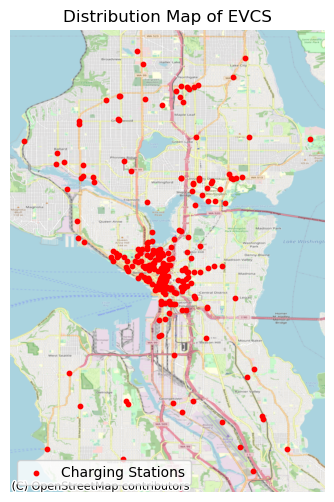

In [24]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(8, 6))
df2.plot(ax=ax, color='red', marker='o', markersize=10, label='Charging Stations') 
plt.title('Distribution Map of EVCS')

ctx.add_basemap(ax, crs=df2.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.legend(loc='lower left')

plt.show()  


In [25]:
import matplotlib.pyplot as plt
joined_gdf = gpd.sjoin(gdf, evcs_gdf, how="inner", op='contains')
joined_gdf

D:\anaconda\anacon\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


OBJECTID            L_HOOD               S_HOOD     S_HOOD_ALT  \
1   28        Ballard           Ballard              Adams           
1   28        Ballard           Ballard              Adams           
1   28        Ballard           Ballard              Adams           
2   29        Ballard           Whittier Heights     NaN             
3   30        Ballard           West Woodland        NaN             
..  ..            ...                     ...        ...             
92  124       Downtown          Denny Triangle       Denny Regrade   
92  124       Downtown          Denny Triangle       Denny Regrade   
92  124       Downtown          Denny Triangle       Denny Regrade   
92  124       Downtown          Denny Triangle       Denny Regrade   
93  126       Greater Duwamish  Industrial District  NaN             

      Shape__Are    Shape__Len  \
1   2.255213e+07  29926.339300   
1   2.255213e+07  29926.339300   
1   2.255213e+07  29926.339300   
2   1.419569e+07  15934.439266   
3   2.219937e+07  21789.651087   
..           ...           ...   
92  5.128172e+06  10574.177983   
92  5.128172e+06  10574.177983   
92  5.128172e+06  10574.177983   
92  5.128172e+06  10574.177983   
93  6.243413e+07  88995.756984   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [26]:
# charging stations within each neighborhood by OBJECTID
counts = joined_gdf.groupby('OBJECTID').size().rename("station_count")

In [27]:
# Consolidation of volume data into neighborhood datasets
gdf = gdf.join(counts, on='OBJECTID', how='left').fillna(0)

In [28]:
# Find the top three rows in the 'station_count' column
top_3_stations = gdf.nlargest(3, 'station_count')
print(top_3_stations)

    OBJECTID    L_HOOD                     S_HOOD                  S_HOOD_ALT  \
35  62        Downtown  Central Business District  Commercial Core, West Edge   
22  49        Cascade   South Lake Union           0                            
92  124       Downtown  Denny Triangle             Denny Regrade                

      Shape__Are    Shape__Len  \
35  9.477399e+06  18209.462862   
22  1.610711e+07  29323.546284   
92  5.128172e+06  10574.177983   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [29]:
# Filter all rows with 'station_count' column greater than 5
filtered_gdf = gdf[gdf['station_count'] > 5]

# Sort by 'station_count' column from highest to lowest
sorted_filtered_gdf = filtered_gdf.sort_values(by='station_count', ascending=False)


print(sorted_filtered_gdf)


    OBJECTID               L_HOOD                     S_HOOD  \
35  62        Downtown             Central Business District   
22  49        Cascade              South Lake Union            
92  124       Downtown             Denny Triangle              
18  45        Queen Anne           Lower Queen Anne            
38  65        Downtown             Pioneer Square              
33  60        Downtown             Belltown                    
36  63        Downtown             First Hill                  
73  100       Capitol Hill         Broadway                    
15  42        University District  University of Washington    
86  116       Northgate            Maple Leaf                  
40  67        Greater Duwamish     SODO                        

                    S_HOOD_ALT    Shape__Are    Shape__Len  \
35  Commercial Core, West Edge  9.477399e+06  18209.462862   
22  0                           1.610711e+07  29323.546284   
92  Denny Regrade               5.128172e+06 

In [30]:
gdf.station_count

0     0.0 
1     3.0 
2     1.0 
3     5.0 
4     2.0 
     ...  
89    1.0 
90    5.0 
91    0.0 
92    19.0
93    1.0 
Name: station_count, Length: 94, dtype: float64

D:\anaconda\anacon\envs\py38\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  warnings.warn(


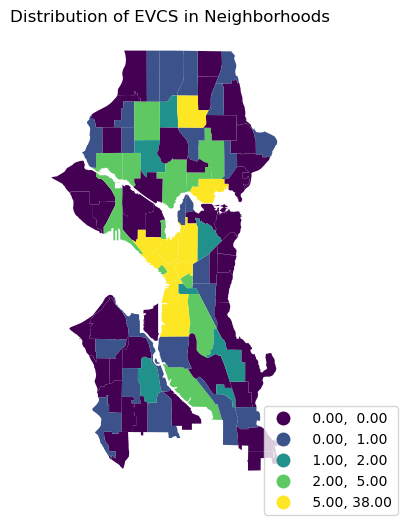

In [31]:
#Thematic mapping of the neighborhood distribution of the number of charging posts
fig, ax = plt.subplots(1, figsize=(8, 6))  # 15 inches wide, 10 inches tall
gdf.plot(ax=ax, column='station_count', scheme='quantiles', k=8, legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 0.2))
ax.set_axis_off()
# Add a title to the map
plt.title('Distribution of EVCS in Neighborhoods')
plt.show()

In [32]:
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import libpysal as lp

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\Lenovo\AppData\Roaming\Python\

In [33]:
#calculate the queen weights 
w_queen = lp.weights.Queen.from_dataframe(gdf)
mi = esda.Moran(gdf['station_count'], w_queen)

('WARNING: ', 43, ' is an island (no neighbors)')


In [34]:
mi = esda.Moran(gdf['station_count'], w_queen) 

In [35]:
#calculate LISA clusters
lisa = esda.Moran_Local(gdf['station_count'], w_queen)

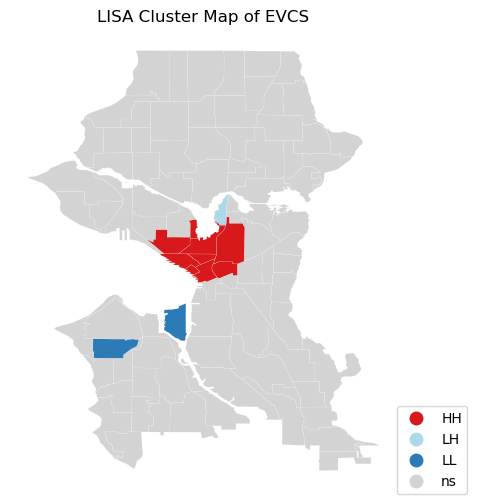

In [36]:
# Visualization of lisa map
fig, ax = plt.subplots(figsize=(8, 6))  
fig, ax = lisa_cluster(lisa, gdf, ax=ax)  # Plotting LISA clusters
leg = ax.get_legend() 
leg.set_bbox_to_anchor((1.2, 0.2)) 

# Add a title to the map
plt.title('LISA Cluster Map of EVCS')

# Show the map
plt.show()


# 6.Maximum Coverage Location Problem (MCLP)

# 6.1 Integration of demand point data

We cluster each neighborhood's center of mass, traffic flow's center of mass, and points of interest as demand points

In [37]:
# Integration of all demand points
frames = [centroids_gdf, selected_roads_gdf, pois_within_neighborhood]
all_demand_points = pd.concat(frames, ignore_index=True)
all_demand_points

geometry    type
0     POINT (-122.35237 47.71686)  census
1     POINT (-122.35542 47.72791)  census
2     POINT (-122.30186 47.71569)  census
3     POINT (-122.37126 47.67601)  census
4     POINT (-122.32604 47.67491)  census
...                           ...     ...
2494  POINT (-122.32495 47.68002)  school
2495  POINT (-122.30492 47.58399)  school
2496  POINT (-122.30596 47.60332)  school
2497  POINT (-122.29018 47.72132)  school
2498  POINT (-122.35888 47.64643)  school

[2499 rows x 2 columns]

## 6.2 Potential facility sites

In [38]:
bus_stops = bus_stops.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df2 = df2.rename(columns={'index_right': 'index_right_df2'})

In [39]:
# add the projected coordinate system before performing the buffer operation
df2_projected = df2.to_crs(epsg=32610)
bus_stops_projected = bus_stops.to_crs(epsg=32610)

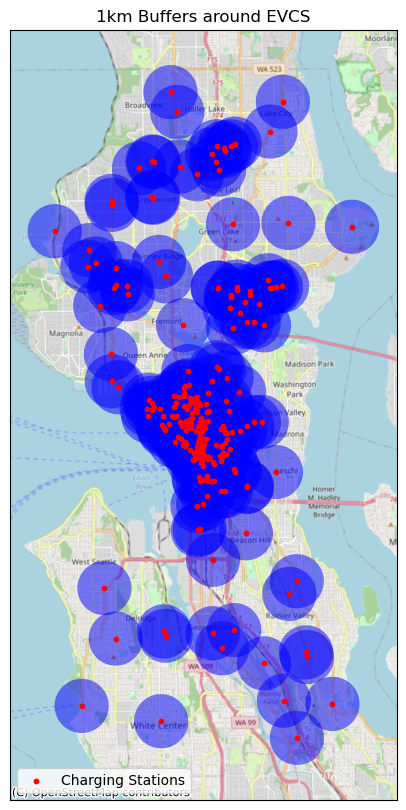

In [40]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

buffer_distance = 1000  # 1km
charging_buffers = df2_projected.buffer(buffer_distance)  # Creating a Buffer

# Create a GeoDataFrame to store the buffer
charging_buffers_gdf = gpd.GeoDataFrame(geometry=charging_buffers)
charging_buffers_gdf.crs = df2_projected.crs  # Ensure that the CRS of the buffer matches the original data

fig, ax = plt.subplots(figsize=(10, 10))

# Visualizing the buffer
charging_buffers_gdf.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Visualize charging stations
df2_projected.plot(ax=ax, color='red', marker='o', markersize=10, label='Charging Stations')

# add basemap
ctx.add_basemap(ax, crs=df2_projected.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Displays the legend and sets the position to the lower left corner
ax.legend(loc='lower left')

# set title
plt.title("1km Buffers around EVCS")

# plot
plt.show()


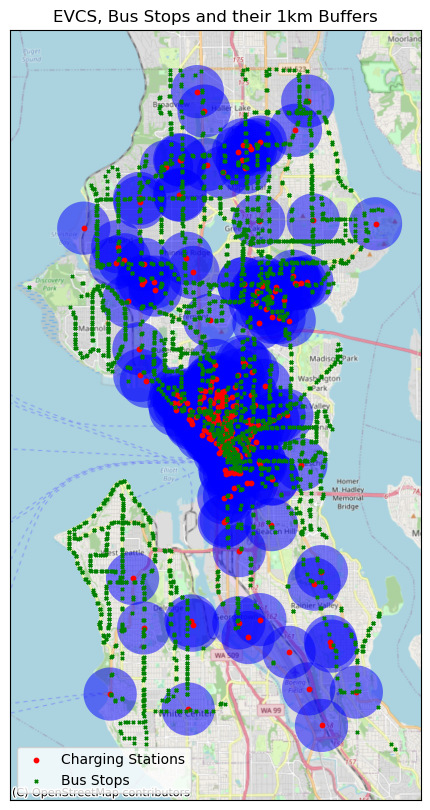

In [41]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

buffer_distance = 1000  # 1km
charging_buffers = df2_projected.buffer(buffer_distance)  # create buffers

# Create a GeoDataFrame to store the buffer
charging_buffers_gdf = gpd.GeoDataFrame(geometry=charging_buffers)
charging_buffers_gdf.crs = df2_projected.crs  # Ensure that the CRS of the buffer matches the original data

fig, ax = plt.subplots(figsize=(10, 10))

# Drawing Buffer
charging_buffers_gdf.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Plotting the points of a charging post
df2_projected.plot(ax=ax, color='red', marker='o', markersize=10, label='Charging Stations')

# Plotting the points of a bus stop
bus_stops_projected.plot(ax=ax, color='green', marker='x', markersize=5, label='Bus Stops')

# add basemap
ctx.add_basemap(ax, crs=df2_projected.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Displays the legend and sets the position to the lower left corner
ax.legend(loc='lower left')
# set title
plt.title("EVCS, Bus Stops and their 1km Buffers")
plt.show()


In [42]:
# Convert charging_buffers to GeoDataFrame
charging_buffers_gdf = gpd.GeoDataFrame(geometry=charging_buffers)

# spatial connectivity
intersections = gpd.sjoin(bus_stops_projected, charging_buffers_gdf, how="inner", predicate="intersects")

# Remove bus stops that intersect any charging post buffer to get bus stops that are outside the buffer only
outside_stations = bus_stops_projected.drop(intersections.index)
outside_stations

highway                           name public_tra gtfs_stop_    ref  \
32    bus_stop  11th Ave NE & NE Ravenna Blvd  platform   23530      23530   
34    bus_stop  12th Ave NE & NE 61st St       platform   23540      23540   
69    bus_stop  15th Ave NE & NE 125th St      platform   38910      38910   
70    bus_stop  15th Ave NE & NE 125th St      platform   39250      39250   
71    bus_stop  15th Ave NE & NE 135th St      platform   38870      38870   
...        ...                        ...           ...     ...        ...   
2397  bus_stop  NaN                            NaN        NaN        NaN     
2398  bus_stop  NaN                            NaN        NaN        NaN     
2409  bus_stop  NaN                            NaN        NaN        NaN     
2410  bus_stop  NaN                            NaN        NaN        NaN     
2411  bus_stop  NaN                            NaN        NaN        NaN     

     gtfs_datas shelter bench route_ref  bin  lit operator tactile_pa covered  \
32    KCGIS      NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
34    KCGIS      NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
69    KCGIS      NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
70    KCGIS      NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
71    KCGIS      NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
...     ...      ...     ...   ...       ...  ...  ...      ...        ...      
2397  NaN        NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
2398  NaN        NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
2409  NaN        NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
2410  NaN        NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      
2411  NaN        NaN     NaN   NaN       NaN  NaN  NaN      NaN        NaN      

     local_ref ref_commun wheelchair network  bus  \
32    NaN       NaN        NaN        NaN     NaN   
34    NaN       NaN        NaN        NaN     NaN   
69    NaN       NaN        NaN        NaN     NaN   
70    NaN       NaN        NaN        NaN     NaN   
71    NaN       NaN        NaN        NaN     NaN   
...   ...       ...        ...        ...     ...   
2397  NaN       NaN        NaN        NaN     NaN   
2398  NaN       NaN        NaN        NaN     NaN   
2409  NaN       NaN        NaN        NaN     NaN   
2410  NaN       NaN        NaN        NaN     NaN   
2411  NaN       NaN        NaN        NaN     NaN   

                            geometry  
32    POINT (551335.644 5279991.941)  
34    POINT (551377.546 5280148.017)  
69    POINT (551542.142 5285297.912)  
70    POINT (551555.545 5285401.910)  
71    POINT (551535.508 5286172.135)  
...                              ...  
2397  POINT (546116.025 5264855.354)  
2398  POINT (546117.273 5265034.816)  
2409  POINT (544579.540 5278442.987)  
2410  POINT (542603.769 5278791.010)  
2411  POINT (550732.833 5286578.405)  

[759 rows x 20 columns]

## 6.3 Number of facilities constructed and radius of service

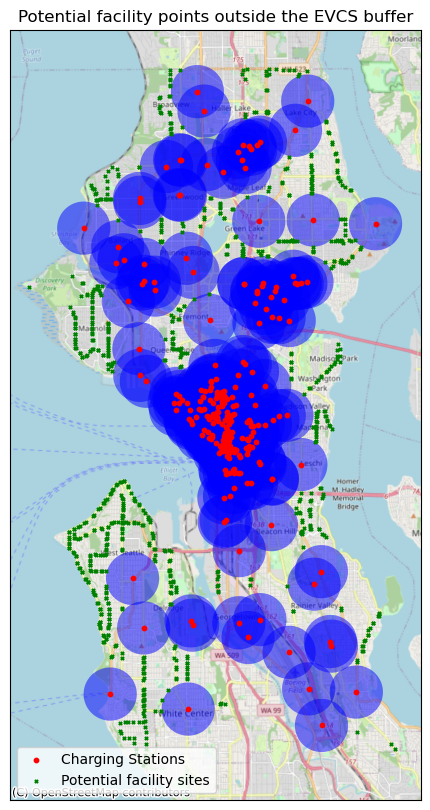

In [43]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

buffer_distance = 1000  # 1km
charging_buffers = df2_projected.buffer(buffer_distance)  # Creating a Buffer

# Create a GeoDataFrame to store the buffer
charging_buffers_gdf = gpd.GeoDataFrame(geometry=charging_buffers)
charging_buffers_gdf.crs = df2_projected.crs  # Ensure that the CRS of the buffer matches the original data

fig, ax = plt.subplots(figsize=(10, 10))

# Visualization Buffer
charging_buffers_gdf.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Plotting the points of EVCS
df2_projected.plot(ax=ax, color='red', marker='o', markersize=10, label='Charging Stations')

# Plotting the points of a bus stop
outside_stations.plot(ax=ax, color='green', marker='x', markersize=5, label='Potential facility sites')

# Add basemap
ctx.add_basemap(ax, crs=df2_projected.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Displays the legend and sets the position to the lower left corner
ax.legend(loc='lower left')
# set title
plt.title("Potential facility points outside the EVCS buffer")
plt.show()


## 6.4 Analysis of existing charging pile coverage

In [44]:
# Converting data to a projected coordinate system
df2_projected = df2.to_crs(epsg=32610)
all_demand_points = all_demand_points.to_crs(epsg=32610)
# Set the buffer zone radius to 1000m
buffer_distance = 1000  # 1km
charging_buffers = df2_projected.buffer(buffer_distance)

In [45]:
# For each demand point, check if it is located within the buffer zone of any of the charging posts.
covered_points = []

for _, point in all_demand_points.iterrows():
    point_geom = point['geometry']
    
    # Check if the point is within any of the buffers.
    for buffer in charging_buffers:
        if point_geom.within(buffer):
            covered_points.append(point.name)
            break  # When an overwritten buffer is found, jump out of the loop to avoid double counting

# Calculate the ratio between the covered demand points and the total demand points
coverage_rate = len(covered_points) / len(all_demand_points)
print(f"Coverage Rate: {coverage_rate:.2%}")


Coverage Rate: 75.47%


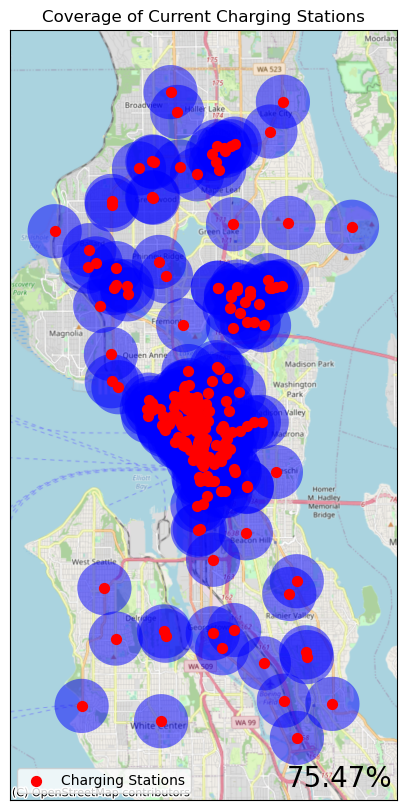

In [46]:
# Create a GeoDataFrame to display the covered demand points
covered_gdf = all_demand_points.loc[covered_points]

fig, ax = plt.subplots(figsize=(10, 10))

# Mapping the 1km buffer of the charging post
charging_buffers.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Mapping the location of charging posts 
df2_projected.plot(ax=ax, color='red', marker='o', markersize=50, label='Charging Stations')

# add basemap
ctx.add_basemap(ax, crs=df2_projected.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border 
ax.set_xticks([])
ax.set_yticks([])

# Labeled coverage
coverage_rate = 75.47
plt.text(0.99, 0.01, f'{coverage_rate}%', 
         transform=ax.transAxes, 
         fontsize=20,  
         color='black', 
         horizontalalignment='right', 
         verticalalignment='bottom')

# Show legend
ax.legend(loc='lower left')

# set the title
plt.title("Coverage of Current Charging Stations")
plt.show()


## 6.5 Optimization Result 

In [47]:
#Define MCLP and solve its function
import pulp

def setup_and_solve_mclp(num_facilities, outside_stations, all_demand_points, df2_projected, service_radius=1000):
    distances = {}
    for facility in outside_stations.iterrows():
        for demand in all_demand_points.iterrows():
            d = facility[1]['geometry'].distance(demand[1]['geometry'])
            distances[(facility[0], demand[0])] = d

    for facility in df2_projected.iterrows():
        for demand in all_demand_points.iterrows():
            d = facility[1]['geometry'].distance(demand[1]['geometry'])
            distances[(facility[0], demand[0])] = d

    coverage = {(facility, demand): 1 if d <= service_radius else 0 for (facility, demand), d in distances.items()}

    prob = pulp.LpProblem("MCLP", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", outside_stations.index, cat=pulp.LpBinary)
    y = pulp.LpVariable.dicts("y", all_demand_points.index, cat=pulp.LpBinary)

    prob += pulp.lpSum(y[j] for j in all_demand_points.index)
    for j in all_demand_points.index:
        prob += pulp.lpSum(x[i] * coverage[(i, j)] for i in outside_stations.index) + \
                pulp.lpSum(coverage[(i, j)] for i in df2_projected.index) >= y[j]
    prob += pulp.lpSum(x[i] for i in outside_stations.index) == num_facilities

    prob.solve()

    covered_demand_points = sum(y[j].varValue for j in all_demand_points.index)
    selected_facilities = [i for i in outside_stations.index if x[i].varValue > 0]

    return covered_demand_points, pulp.LpStatus[prob.status], selected_facilities


In [48]:
# This loop prioritizes charging post sites to meet 80%, 85%, and 90% coverage targets
min_facilities = 1
max_facilities = 20
total_demand_points = len(all_demand_points)

facilities_over_80 = None
facilities_over_85 = None
facilities_over_90 = None

num_facilities_list = []
coverage_rate_list = []

for num_facilities in range(min_facilities, max_facilities + 1):
    covered_demand_points, status, selected_facilities = setup_and_solve_mclp(num_facilities, outside_stations, all_demand_points, df2_projected)
    
    if status == 'Optimal':
        coverage_rate = (covered_demand_points / total_demand_points) * 100
        print(f"Number of facilities: {num_facilities}, Covered demand points: {covered_demand_points}, Coverage Rate: {coverage_rate:.2f}%")
        
        # Add the number of charging piles per iteration and the corresponding coverage to the list
        num_facilities_list.append(num_facilities)
        coverage_rate_list.append(coverage_rate)
        
        if coverage_rate > 80 and facilities_over_80 is None:
            facilities_over_80 = selected_facilities
        
        if coverage_rate > 85 and facilities_over_85 is None:
            facilities_over_85 = selected_facilities
            
        if coverage_rate > 90 and facilities_over_90 is None:
            facilities_over_90 = selected_facilities
            print("Coverage rate is over 90%. Stopping the iteration.")
            break  # Add the number of charging piles per iteration and the corresponding coverage to the list
        
    else:
        print(f"Number of facilities: {num_facilities}, Problem Status: {status}")



Number of facilities: 1, Covered demand points: 1957.0, Coverage Rate: 78.31%
Number of facilities: 2, Covered demand points: 2023.0, Coverage Rate: 80.95%
Number of facilities: 3, Covered demand points: 2074.0, Coverage Rate: 82.99%
Number of facilities: 4, Covered demand points: 2109.0, Coverage Rate: 84.39%
Number of facilities: 5, Covered demand points: 2142.0, Coverage Rate: 85.71%
Number of facilities: 6, Covered demand points: 2173.0, Coverage Rate: 86.95%
Number of facilities: 7, Covered demand points: 2203.0, Coverage Rate: 88.16%
Number of facilities: 8, Covered demand points: 2224.0, Coverage Rate: 89.00%
Number of facilities: 9, Covered demand points: 2244.0, Coverage Rate: 89.80%
Number of facilities: 10, Covered demand points: 2258.0, Coverage Rate: 90.36%
Coverage rate is over 90%. Stopping the iteration.


In [49]:
#Find the number of nodes(80%, 85%, 90%) to cover the selection of charging piles
def create_geodataframe(facilities):
    return outside_stations.loc[facilities]

df_facilities_over_80 = create_geodataframe(facilities_over_80)
df_facilities_over_85 = create_geodataframe(facilities_over_85)
df_facilities_over_90 = create_geodataframe(facilities_over_90)

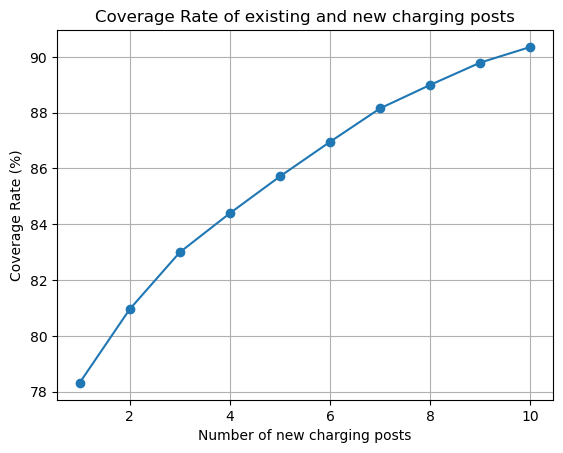

In [50]:
# Plotting graphs
plt.plot(num_facilities_list, coverage_rate_list, marker='o')
plt.title('Coverage Rate of existing and new charging posts')
plt.xlabel('Number of new charging posts')
plt.ylabel('Coverage Rate (%)')
plt.grid(True)
plt.show()

In [64]:
df_facilities_over_80.name

1051    East Green Lake Dr N & Orin Ct N    
2288    West Viewmont Way W & Westmont Way W
Name: name, dtype: object

In [65]:
df_facilities_over_85.name

1055    East Green Lake Dr N & Wallingford Ave N
1579    NE 125th St & 15th Ave NE               
2238    Viewmont Way W & 35th Ave W             
2293    West Viewmont Way W & W Ruffner St      
2343    Woodlawn Ave N & N 63rd St              
Name: name, dtype: object

In [66]:
df_facilities_over_90.name

487     35th Ave SW & SW Elmgrove St            
1055    East Green Lake Dr N & Wallingford Ave N
1318    Harbor Ave SW & SW Harbor Ln            
1352    Kirkwood Pl N & N 59th St               
1595    NE 125th St & Roosevelt Way NE          
1600    NE 145th St & 23rd Pl NE                
1648    NE 55th St & Princeton Ave NE           
1923    Ravenna Ave NE & NE 86th St             
2238    Viewmont Way W & 35th Ave W             
2293    West Viewmont Way W & W Ruffner St      
Name: name, dtype: object

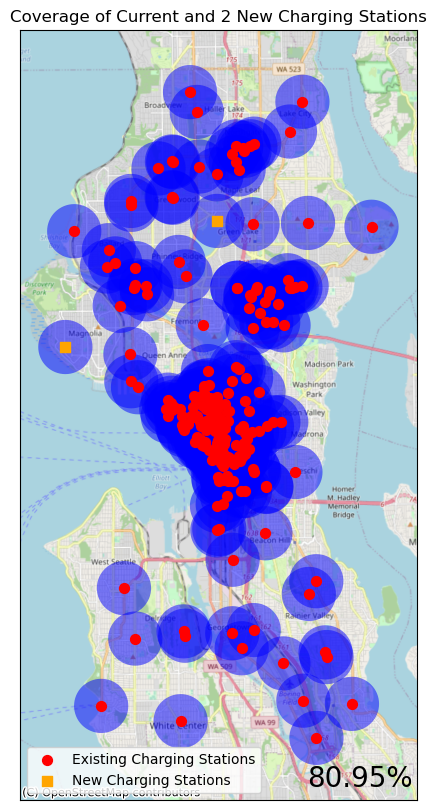

In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Consolidation of 2 new charging posts with original charging posts
all_stations_gdf_over80 = pd.concat([df2_projected, df_facilities_over_80])

# Generate a 1km buffer
buffer_distance = 1000  # 1km
charging_buffers = all_stations_gdf_over80.buffer(buffer_distance)

fig, ax = plt.subplots(figsize=(10, 10))

# Mapping of 1km buffer zones for charging posts
charging_buffers.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Mapping the location of the original charging post (old site)
df2_projected.plot(ax=ax, color='red', marker='o', markersize=50, label='Existing Charging Stations')

# Mapping the location of new charging posts (new stations)
df_facilities_over_80.plot(ax=ax, color='orange', marker='s', markersize=50, label='New Charging Stations')

# add basemap
ctx.add_basemap(ax, crs=all_stations_gdf_over80.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Labeled coverage
coverage_rate = 80.95  
plt.text(0.99, 0.01, f'{coverage_rate}%', 
         transform=ax.transAxes, 
         fontsize=20,
         color='black', 
         horizontalalignment='right', 
         verticalalignment='bottom')

# Show legend
ax.legend(loc='lower left')

# set the title
plt.title("Coverage of Current and 2 New Charging Stations")
plt.show()


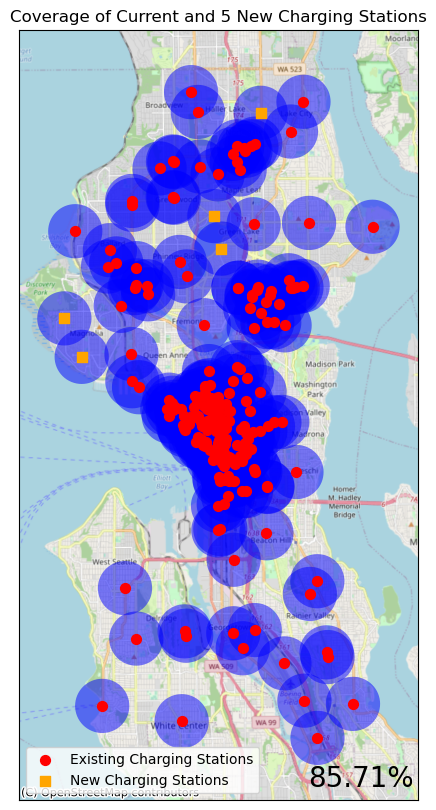

In [55]:
# Consolidation of 5 new charging posts with original charging posts
all_stations_gdf_over85 = pd.concat([df2_projected, df_facilities_over_85])

# Generate a 1km buffer
buffer_distance = 1000  # 1km
charging_buffers = all_stations_gdf_over85.buffer(buffer_distance)

fig, ax = plt.subplots(figsize=(10, 10))

# Mapping of 1km buffer zones for charging posts
charging_buffers.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Mapping the location of the original charging post (old site)
df2_projected.plot(ax=ax, color='red', marker='o', markersize=50, label='Existing Charging Stations')

# Mapping the location of new charging posts (new stations)
df_facilities_over_85.plot(ax=ax, color='orange', marker='s', markersize=50, label='New Charging Stations')

# add basemap
ctx.add_basemap(ax, crs=all_stations_gdf_over85.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Labeled coverage
coverage_rate = 85.71  
plt.text(0.99, 0.01, f'{coverage_rate}%', 
         transform=ax.transAxes, 
         fontsize=20,
         color='black', 
         horizontalalignment='right', 
         verticalalignment='bottom')

# Show legend
ax.legend(loc='lower left')

# set the title
plt.title("Coverage of Current and 5 New Charging Stations")
plt.show()


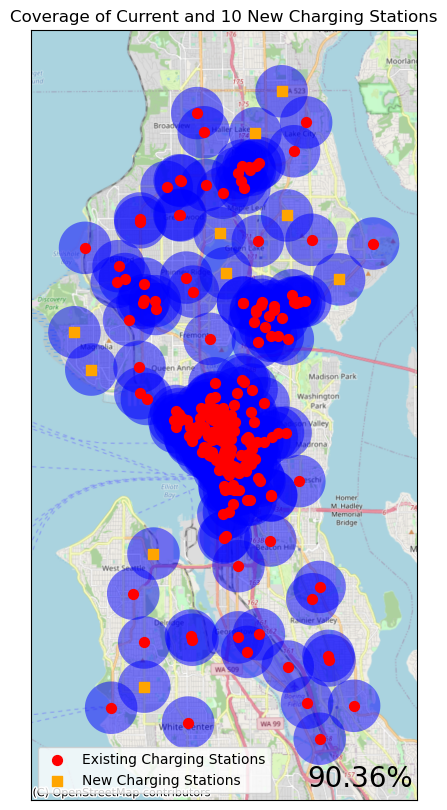

In [56]:
# Consolidation of 10 new charging posts with original charging posts
all_stations_gdf_over90 = pd.concat([df2_projected, df_facilities_over_90])

# Generate a 1km buffer
buffer_distance = 1000  # 1km
charging_buffers = all_stations_gdf_over90.buffer(buffer_distance)

fig, ax = plt.subplots(figsize=(10, 10))

# Mapping of 1km buffer zones for charging posts
charging_buffers.plot(ax=ax, color='blue', alpha=0.5, label='1km Buffers')

# Mapping the location of the original charging post (old site)
df2_projected.plot(ax=ax, color='red', marker='o', markersize=50, label='Existing Charging Stations')

# Mapping the location of new charging posts (new stations)
df_facilities_over_90.plot(ax=ax, color='orange', marker='s', markersize=50, label='New Charging Stations')

# add basemap
ctx.add_basemap(ax, crs=all_stations_gdf_over90.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Remove the latitude and longitude coordinates from the border
ax.set_xticks([])
ax.set_yticks([])

# Labeled coverage
coverage_rate = 90.36  
plt.text(0.99, 0.01, f'{coverage_rate}%', 
         transform=ax.transAxes, 
         fontsize=20,
         color='black', 
         horizontalalignment='right', 
         verticalalignment='bottom')

# 
ax.legend(loc='lower left')

# Set the title
plt.title("Coverage of Current and 10 New Charging Stations")
plt.show()


# 7. Conclusion

In this study, the maximum coverage problem was used to optimize the distribution of electric vehicle charging stations in Seattle. A 1-kilometer buffer was created on top of Seattle's existing 255 EV charging stations to calculate coverage. 758 bus stops that are not in the buffer zone are screened as potential facilities. The demand point model including the center of mass in the census area, the average traffic flow on weekdays, and the points of interest (residential area, commercial area, school, hospital) were developed, and finally the binary maximum coverage model was used to solve the problem, and the coverage thresholds were 80%, 85% and 90%. The results show that with just 10 new charging points, the coverage of electric vehicle charging stations in Seattle can be significantly increased to 90%. The coverage rate (75.47%) is almost 15% higher than before the bus station was converted into a new charging station. The addition of 2 new EV charging stations in North Seattle can increase the coverage rate to more than 80%, and the addition of 5 new charging stations can increase the coverage rate to more than 85%, greatly improving the coverage of EV charging stations. The methods and results can provide suggestions for optimizing the location of electric vehicle charging piles and promote the development of urban transportation in the direction of clean and environmentally friendly.  

# References

1.Struben, J. and Sterman, J.D. (2008). Transition Challenges for Alternative Fuel Vehicle and Transportation Systems. Environment and planning. B, Planning & design, 35(6), pp.1070–1097.  
2.Seattle Department of Transportation, 2023. Electric Vehicle Charging in the Public Right-of-Way. Available at: https://www.seattle.gov/transportation/projects-and-programs/programs/new-mobility-program/electric-vehicle-charging-in-the-public-right-of-way [Accessed 17 August 2023].  